# Disease Outbreak Predictor
Course: CPE 3018 – Numerical Methods <br>
Project: Data-Driven Disease Outbreak Predictor <br>
Language: Python (Jupyter Notebook) <br>

Overview <br>
This notebook implements a disease outbreak predictor based on Newton's Divided Difference Method. It:
1. Uses a small number of time-based data points (days vs. cases/deaths).
2. Builds an approximating polynomial using divided differences.
3. Performs:
 - Interpolation (estimating missing data within the time range).
 - Extrapolation (estimating future cases beyond the time range).
4. Provides plots which shows the:
 - Observed data
 - Interpolated curve
 - Extrapolated future predictions

## 0. Project Setup

In [24]:
# Import libraries
import numpy as np                  # For numerical computations, arrays, math
import pandas as pd                 # For tabular display and basic data manipulation
import matplotlib.pyplot as plt     # For plotting and visualization
import warnings

# Suppress non-critical
warnings.filterwarnings('ignore')

# Improve output readability
np.set_printoptions(precision=6, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## 1. Class Implementations

### 1.1. Divided Difference Method Implementation
 - This class implements the Divided Difference method with Newton polynomials <br>

Contains the following methods: <br>
> **_comp_dd**: Constructs the divided differences table <br>
> **evaluate**: Evaluates the resulting interpolating polynomial for any x (interpolation or extrapolation) <br>
> **print_dd_table**: Provides a console printout of the divided differences table <br>

In [25]:
class NewtonDividedDifference:
    """
    Newton's Divided Difference Interpolation Method

    Attributes:
        x_data (np.array): Time points (independent variable)
        y_data (np.array): Case/death counts (dependent variable)
        n (int): Number of data points
        dd_table (np.array): 2D array of divided differences
    """

    def __init__(self, x_data, y_data):
        """
        Args:
            x_data (list/array): Time values (e.g., days)
            y_data (list/array): Case or death counts
        """
        self.x_data = np.array(x_data, dtype=float)
        self.y_data = np.array(y_data, dtype=float)
        self.n = len(self.x_data)

        # Basic input validation
        if len(self.x_data) != len(self.y_data):
            raise ValueError("x_data and y_data must have the same length")
        if self.n < 2:
            raise ValueError("At least 2 data points are required")

        # Sort data by x-values to maintain proper order
        sorted_indices = np.argsort(self.x_data)
        self.x_data = self.x_data[sorted_indices]
        self.y_data = self.y_data[sorted_indices]

        # Compute the divided differences table once at initialization
        self.dd_table = self._comp_dd()

    def _comp_dd(self):
        """
        Compute the divided differences table.

        The table is n x n, where:
        - Column 0: f[x_i] (the original function values)
        - Column 1: f[x_i, x_{i+1}] (first-order divided differences)
        - Column 2: f[x_i, x_{i+1}, x_{i+2}] (second-order)
        - etc. to column n

        Returns:
            np.array: (n x n) divided differences table
        """
        # Output variable
        diff_table = np.zeros((self.n, self.n))       # Initialize with zeros
        diff_table[:, 0] = self.y_data                                  # Put the data values in the first column

        # Fill the rest of the table using the divided difference formula
        for j in range(1, self.n):          # column (order of difference)
            for i in range(self.n - j):     # row
                numerator = diff_table[i+1, j-1] - diff_table[i, j-1]
                denominator = self.x_data[i+j] - self.x_data[i]
                diff_table[i, j] = numerator / denominator

        return diff_table

    def evaluate(self, x):
        """
        Evaluate the Newton interpolating polynomial at one or more points.

        Uses a nested multiplication scheme for evaluation:
        P(x) = a_0 + (x-x_0)[a_1 + (x-x_1)[a_2 + ...]]

        Args:
            x (float/array): Point(s) at which to evaluate P(x)

        Returns:
            float/np.array: Interpolated (or extrapolated) values
        """
        # Input handling
        x = np.atleast_1d(x)

        # Output variable
        results = np.zeros_like(x, dtype=float)

        # Evaluate the polynomial at each x-value
        for idx, x_val in enumerate(x):
            # Start with the highest-order coefficient
            result = self.dd_table[0, self.n - 1]

            # Horner-like scheme going backward through columns
            for j in range(self.n - 2, -1, -1):
                result = result * (x_val - self.x_data[j]) + self.dd_table[0, j]

            # Final result saved to array
            results[idx] = result

        return results if len(results) > 1 else results[0]      # If the input was scalar, return scalar; else return array

    def show_ddTable(self):
        """
        Displays the divided differences table as a nicely formatted DataFrame.
        """
        try:
            # Creating the table with a DataFrame
            df = pd.DataFrame(self.dd_table[:, :],
                            index=[f'x_{i}={x:.0f}' for i, x in enumerate(self.x_data)])
            column_names = ['f[x_i]']
            
            # Generating the headers
            for i in range(1, self.n):
                column_names.append(f'f[x_i...x_{i}]')
            df.columns = column_names[:self.n]

            print(df)
        except Exception as e:
            print(f"Error displaying divided differences table")
            print(f"[{e}]")

### 1.2. Disease Outbreak Predictor Class
 - This class is the main class that actually generates new data, either filling in missing data using interpolation or predicting future data using extrapolation.

Contains the following methods: <br>
> **input_data**: Public method to input observed case and deaths data <br>
> **interpolate**: Fills in missing data <br>
> **extrapolate**: Predicts future data <br>
> **retrieve_table**: Provides a console printout of the internally generated divided difference table

In [26]:
class DiseaseOutbreakPredictor:
    """ Data-Driven Disease Outbreak Predictor """
    def __init__(self):
        self.days = None
        self.data = None
        self.data_name = None
        self.approximator = None
        self.table = None

    def add_data(self, days, data_name, data):
        # List of days must be provided
        if days is None or len(days) == 0:
            raise ValueError("List of days must be provided!")
        self.days = np.array(days, dtype=float)

        # data_name should be a string
        if not isinstance(data_name, str) or data_name.strip() == "":
            raise ValueError("Data name must be a non-empty string")
        self.data_name = data_name

        # Input handling for list of data
        if data is None or len(data) != len(self.days):
            raise ValueError(f"{data_name} and days are not of the same size!")
        self.data = np.array(data, dtype=float)

        # Fill data to table
        try:
            self.table = pd.DataFrame({
                'Day': self.days.astype(int),
                self.data_name : self.data.astype(float)
            })
            self.table[f"{self.data_name} (Rounded)"] = np.ceil(self.data).astype(int)
            self.table["Source"] = "Observed"
        except:
            raise Exception("Table was not properly filled up!")

        # Create approximators only when there are at least 2 data points
        self.approximator = None
        if self.data.size >= 2:
            self.approximator = NewtonDividedDifference(self.days, self.data)


    def _approximate(self, x_days):
        """Shared private method for interpolation and extrapolation."""
        
        if self.approximator is None:
            raise ValueError(f"Not enough data points to create an approximator for {self.data_name}")
        
        x_arr = np.array(x_days, dtype=float)
        predictions = np.maximum(self.approximator.evaluate(x_arr), 0)

        return predictions

    def interpolate(self, fine = 0):
        """Interpolate values for given days inside the known range."""

        # fine should be a 0 or positive
        if not (isinstance(fine, (int, np.integer)) and fine >= 0):
            raise ValueError("fine should be 0 or positive!")
        
        if (fine == 0): # Default behavior which fills in missing days from day 1 up until the last day in the data
            observed_days_int = set(np.array(self.days, dtype=int))
            full_days = np.arange(1, int(self.days.max()) + 1)
            days_to_interpolate = [int(d) for d in full_days if int(d) not in observed_days_int]
        else:           # Otherwise, fine indicates the number of points to fill within the range.
            days_to_interpolate = np.linspace(self.days.min(), self.days.max(), fine)

        res = self._approximate(days_to_interpolate).astype(float)

        insert_data = pd.DataFrame({
            'Day' : days_to_interpolate,
            self.data_name : res
        })
        insert_data[f"{self.data_name} (Rounded)"] = np.ceil(res).astype(int)
        insert_data["Source"] = "Interpolated" if (fine == 0) else "Interpolated (smooth)"

        self.table = pd.concat([self.table, insert_data], ignore_index=True)
        self.table = self.table.sort_values('Day').reset_index(drop=True)

    def extrapolate(self, fine = 0, extend = 1.5):
        """Extrapolate values for days outside the observed data range."""
        
        # fine should be a a positive integer or 0
        if not (isinstance(fine, (int, np.integer)) and fine >= 0):
            raise ValueError("fine should be a positive integer or 0!")
        
        # extend should be greater than 1.5
        if (extend < 1.5):
            raise ValueError("extend should be greater than 1.5!")
        
        # Determine the last day
        max_day = int(np.max(self.days))
        end_day = int(np.ceil(extend * max_day))
        
        if (fine == 0): # Default behavior which generate future days for extrapolation up to multiplier defined by extend
            future_days = list(np.arange(max_day + 1, end_day + 1))
        else:           # Otherwise, fine indicates the number of points to fill within the range.
            future_days = np.linspace(self.days.max(), end_day, fine)

        res = self._approximate(future_days).astype(float)

        insert_data = pd.DataFrame({
            'Day' : future_days,
            self.data_name : res
        })
        insert_data[f"{self.data_name} (Rounded)"] = np.ceil(res).astype(int)
        insert_data["Source"] = "Extrapolated" if (fine == 0) else "Extrapolated (smooth)"

        self.table = pd.concat([self.table, insert_data], ignore_index=True)
        self.table = self.table.sort_values('Day').reset_index(drop=True)

    def show_dataTable(self, filter=[]):
        """Display the data table with optional filtering."""      
        try:
            if not isinstance(filter, list):
                raise ValueError("filter should be a list of source values to exclude")

            if len(filter) == 0:
                display_table = self.table.copy()
            else:
                display_table = self.table[self.table['Source'].isin(filter)].copy()

            print(display_table.to_string(index=False))
            print()
        except Exception as e:
            print(f"No {self.data_name} data available to display")
            print(f"[{e}]")

    def show_ddTable(self):
        """Get the divided differences table for cases or deaths, if available."""
        try:
            self.approximator.show_ddTable()
        except Exception as e:
            print(f"No {self.data_name} data available to display")
            print(f"[{e}]")
    
    def summary(self, filter = ["Observed", "Interpolated", "Extrapolated"]):
        """Summary of the input data state."""
        try:
            if not isinstance(filter, list) or len(filter) == 0:
                raise ValueError("filter should be a list of source values to include")

            if self.table is None:
                raise Exception("No table available")

            if len(filter) == 0:
                sum_val = self.table[self.data_name].sum()

                print( pd.DataFrame([{
                'Number of data points': int(self.days.size),
                'Range of days': (f"Days {self.table['Day'].min():.0f} to {self.table['Day'].max():.0f}" if self.days.size > 0 else 'N/A'),
                f'Range of {self.data_name}': (f"{self.table[self.data_name].min():.0f} to {self.table[self.data_name].max():.0f}" if self.data.size > 0 else 'N/A'),
                f'Sum of {self.data_name}': f"{sum_val:.0f}"
                    }]).iloc[0].to_string())
                print()
            else:
                sum_val = self.table[self.table['Source'].isin(filter)][self.data_name].sum()

                print( pd.DataFrame([{
                'Number of data points': int(self.days.size),
                f'Sum of {self.data_name} in {", ".join(filter)}': f"{sum_val:.0f}"
                    }]).iloc[0].to_string())
                print()


        except Exception as e:
            print(f"No {self.data_name} data available to display")
            print(f"[{e}]")

## 2. Start of Data Analysis
 - To demonstrate the algorithm in action, a sample outbreak dataset is provided.
 - Modify values as desired, and when finished, click "Run cell and below" to recalculate from new data.

In [27]:
days_observed = [1, 3, 5, 7, 10]
cases_observed = [50, 120, 280, 650, 1800]
deaths_observed = [5, 4, 5, 7, 8]

cases = DiseaseOutbreakPredictor()
deaths = DiseaseOutbreakPredictor()

try:
    cases.add_data(days_observed, "Cases", cases_observed)
except Exception as e:
    print(f"No cases data available to display")
    print(f"[{e}]")

try:
    deaths.add_data(days_observed, "Deaths", deaths_observed)
except Exception as e:
    print(f"No deaths data available to display")
    print(f"[{e}]")

### Input data in tabular form:

In [28]:
cases.show_dataTable()

 Day  Cases  Cases (Rounded)   Source
   1   50.0               50 Observed
   3  120.0              120 Observed
   5  280.0              280 Observed
   7  650.0              650 Observed
  10 1800.0             1800 Observed



In [29]:
deaths.show_dataTable()

 Day  Deaths  Deaths (Rounded)   Source
   1     5.0                 5 Observed
   3     4.0                 4 Observed
   5     5.0                 5 Observed
   7     7.0                 7 Observed
  10     8.0                 8 Observed



### Summary of input data:

In [30]:
cases.summary()

Number of data points                                      5
Sum of Cases in Observed, Interpolated, Extrapolated    2900



In [31]:
deaths.summary()

Number of data points                                     5
Sum of Deaths in Observed, Interpolated, Extrapolated    29



## 3. Divided Differences Analysis
 - We inspect the divided difference tables for cases and deaths (if available).

### Divided Differences Table for Cases:

In [32]:
cases.show_ddTable()

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1     50.0     35.000000     11.250000      2.500000     -0.064815
x_1=3    120.0     80.000000     26.250000      1.916667      0.000000
x_2=5    280.0    185.000000     39.666667      0.000000      0.000000
x_3=7    650.0    383.333333      0.000000      0.000000      0.000000
x_4=10  1800.0      0.000000      0.000000      0.000000      0.000000


### Divided Differences Table for Deaths:

In [33]:
deaths.show_ddTable()

        f[x_i]  f[x_i...x_1]  f[x_i...x_2]  f[x_i...x_3]  f[x_i...x_4]
x_0=1      5.0     -0.500000      0.250000     -0.020833     -0.001786
x_1=3      4.0      0.500000      0.125000     -0.036905      0.000000
x_2=5      5.0      1.000000     -0.133333      0.000000      0.000000
x_3=7      7.0      0.333333      0.000000      0.000000      0.000000
x_4=10     8.0      0.000000      0.000000      0.000000      0.000000


## 4. Interpolation: Estimating Missing Values
 - We first determine which days are missing in the input data

In [34]:
try:
    cases.interpolate()
except Exception as e:
    print(f"No cases data available to interpolate")
    print(f"[{e}]")

In [35]:
try:
    deaths.interpolate()
except Exception as e:
    print(f"No deaths data available to interpolate")
    print(f"[{e}]")

 - These values 'fill in the gaps' on days when no data was recorded
 - Because these days are inside the observed range, interpolation is relatively reliable.

### Approximated cases data:

In [36]:
cases.show_dataTable(["Interpolated"])
cases.summary(["Interpolated"])

 Day       Cases  Cases (Rounded)       Source
   2   82.222222               83 Interpolated
   4  180.666667              181 Interpolated
   6  432.222222              433 Interpolated
   8  944.444444              945 Interpolated
   9 1325.111111             1326 Interpolated

Number of data points              5
Sum of Cases in Interpolated    2965



In [37]:
deaths.show_dataTable(["Interpolated"])
deaths.summary(["Interpolated"])

 Day   Deaths  Deaths (Rounded)       Source
   2 4.214286                 5 Interpolated
   4 4.296429                 5 Interpolated
   6 5.964286                 6 Interpolated
   8 7.875000                 8 Interpolated
   9 8.314286                 9 Interpolated

Number of data points             5
Sum of Deaths in Interpolated    31



## 5. Extrapolation: Future Predictions
 - The same exact method can be done to predict cases and deaths for future days.

In [38]:
try:
    cases.extrapolate()
except Exception as e:
    print(f"No cases data available to extrapolate")
    print(f"[{e}]")

In [39]:
try:
    deaths.extrapolate()
except Exception as e:
    print(f"No deaths data available to extrapolate")
    print(f"[{e}]")

 - Predictions near the last day are more reasonable.
 - Predictions far from the last day are highly uncertain.
 - Of course, real outbreaks also depend on interventions, behavior, and many other factors not accounted for in this heavily simplified model.

In [40]:
cases.show_dataTable(["Extrapolated"])
cases.summary(["Extrapolated"])

 Day       Cases  Cases (Rounded)       Source
  11 2375.555556             2376 Extrapolated
  12 3056.666667             3057 Extrapolated
  13 3846.666667             3847 Extrapolated
  14 4747.333333             4748 Extrapolated
  15 5758.888889             5759 Extrapolated

Number of data points               5
Sum of Cases in Extrapolated    19785



In [41]:
deaths.show_dataTable(["Extrapolated"])
deaths.summary(["Extrapolated"])

 Day   Deaths  Deaths (Rounded)       Source
  11 6.571429                 7 Extrapolated
  12 3.625000                 4 Extrapolated
  13 0.000000                 0 Extrapolated
  14 0.000000                 0 Extrapolated
  15 0.000000                 0 Extrapolated

Number of data points             5
Sum of Deaths in Extrapolated    10



In [42]:
cases.show_dataTable()
cases.summary()

 Day       Cases  Cases (Rounded)       Source
   1   50.000000               50     Observed
   2   82.222222               83 Interpolated
   3  120.000000              120     Observed
   4  180.666667              181 Interpolated
   5  280.000000              280     Observed
   6  432.222222              433 Interpolated
   7  650.000000              650     Observed
   8  944.444444              945 Interpolated
   9 1325.111111             1326 Interpolated
  10 1800.000000             1800     Observed
  11 2375.555556             2376 Extrapolated
  12 3056.666667             3057 Extrapolated
  13 3846.666667             3847 Extrapolated
  14 4747.333333             4748 Extrapolated
  15 5758.888889             5759 Extrapolated

Number of data points                                       5
Sum of Cases in Observed, Interpolated, Extrapolated    25650



In [43]:
deaths.show_dataTable()
deaths.summary()

 Day   Deaths  Deaths (Rounded)       Source
   1 5.000000                 5     Observed
   2 4.214286                 5 Interpolated
   3 4.000000                 4     Observed
   4 4.296429                 5 Interpolated
   5 5.000000                 5     Observed
   6 5.964286                 6 Interpolated
   7 7.000000                 7     Observed
   8 7.875000                 8 Interpolated
   9 8.314286                 9 Interpolated
  10 8.000000                 8     Observed
  11 6.571429                 7 Extrapolated
  12 3.625000                 4 Extrapolated
  13 0.000000                 0 Extrapolated
  14 0.000000                 0 Extrapolated
  15 0.000000                 0 Extrapolated

Number of data points                                     5
Sum of Deaths in Observed, Interpolated, Extrapolated    70



## 7. Data Visualization
This section generates plots:
 - Cases (observed, interpolation, extrapolation)
 - Deaths (observed, interpolation, extrapolation)


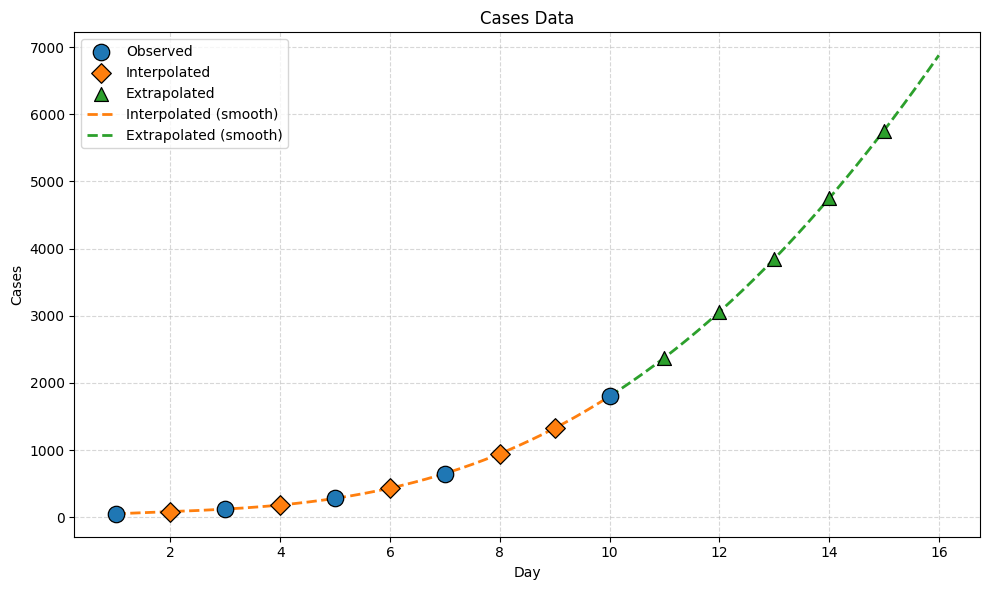

In [44]:
try:
    plt.figure(figsize=(10,6))

    # Integer days as points in the plot
    marker_map = {'Observed': 'o', 'Interpolated': 'D', 'Extrapolated': '^'}
    color_map = {'Observed': 'C0', 'Interpolated': 'C1', 'Extrapolated': 'C2'}
    size_map = {'Observed': 140, 'Interpolated': 100, 'Extrapolated': 100}

    for src in ['Observed', 'Interpolated', 'Extrapolated']:
        subset = cases.table[cases.table['Source'] == src]
        plt.scatter(subset['Day'], subset['Cases'],
                    marker=marker_map[src],
                    s=size_map[src],
                    c=color_map[src],
                    edgecolor='k',
                    linewidth=0.9,
                    label=f'{src}',
                    zorder=6)

    # Generate points in between the integer days
    cases.interpolate(fine = 300)
    cases.extrapolate(fine = 300, extend = 1.6)

    # Smooth interpolated curve
    x_interp = cases.table[cases.table['Source'] == 'Interpolated (smooth)']['Day']
    y_smooth_interp = np.atleast_1d(cases.table[cases.table['Source'] == 'Interpolated (smooth)']['Cases'])
    plt.plot(x_interp, y_smooth_interp, label='Interpolated (smooth)', linestyle='--', c='C1', linewidth=2, zorder=3)

    # Smooth extrapolated curve
    x_extrap = cases.table[cases.table['Source'] == 'Extrapolated (smooth)']['Day']
    y_smooth_extrap = np.atleast_1d(cases.table[cases.table['Source'] == 'Extrapolated (smooth)']['Cases'])
    plt.plot(x_extrap, y_smooth_extrap, label='Extrapolated (smooth)', linestyle='--', c='C2', linewidth=2, zorder=2)

    plt.xlabel('Day')
    plt.ylabel('Cases')
    plt.title('Cases Data')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Cannot plot cases data")
    print(f"[{e}]")

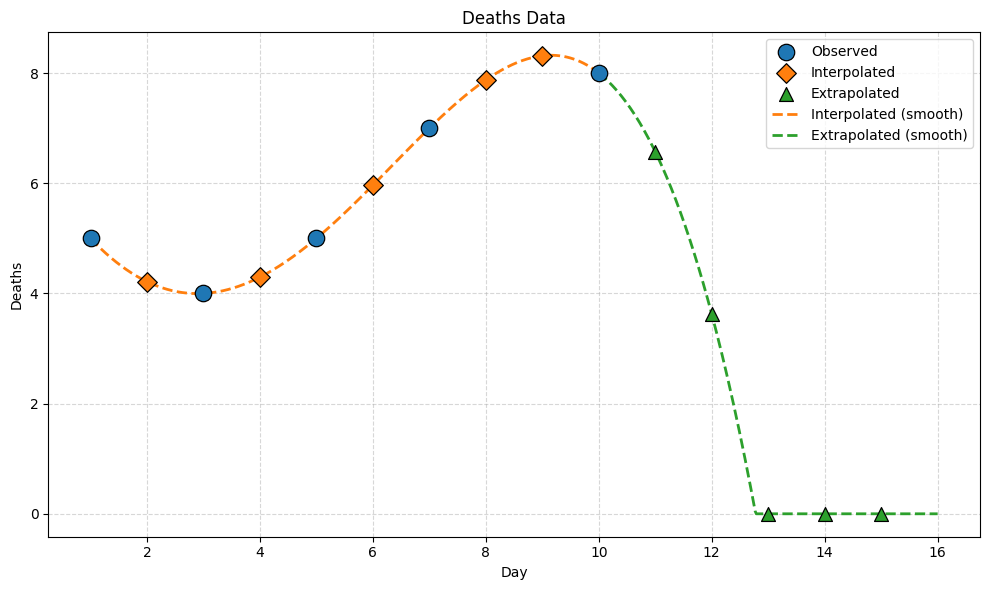

In [45]:
try:
    plt.figure(figsize=(10,6))

    # Integer days as points in the plot
    marker_map = {'Observed': 'o', 'Interpolated': 'D', 'Extrapolated': '^'}
    color_map = {'Observed': 'C0', 'Interpolated': 'C1', 'Extrapolated': 'C2'}
    size_map = {'Observed': 140, 'Interpolated': 100, 'Extrapolated': 100}

    for src in ['Observed', 'Interpolated', 'Extrapolated']:
        subset = deaths.table[deaths.table['Source'] == src]
        plt.scatter(subset['Day'], subset['Deaths'],
                    marker=marker_map[src],
                    s=size_map[src],
                    c=color_map[src],
                    edgecolor='k',
                    linewidth=0.9,
                    label=f'{src}',
                    zorder=6)
    
    # Generate points in between the integer days
    deaths.interpolate(fine = 300)
    deaths.extrapolate(fine = 300, extend = 1.6)

    # Smooth interpolated curve
    x_interp = deaths.table[deaths.table['Source'] == 'Interpolated (smooth)']['Day']
    y_smooth_interp = np.atleast_1d(deaths.table[deaths.table['Source'] == 'Interpolated (smooth)']['Deaths'])
    plt.plot(x_interp, y_smooth_interp, label='Interpolated (smooth)', linestyle='--', c='C1', linewidth=2, zorder=3)
    
    # Smooth extrapolated curve
    x_extrap = deaths.table[deaths.table['Source'] == 'Extrapolated (smooth)']['Day']
    y_smooth_extrap = np.atleast_1d(deaths.table[deaths.table['Source'] == 'Extrapolated (smooth)']['Deaths'])
    plt.plot(x_extrap, y_smooth_extrap, label='Extrapolated (smooth)', linestyle='--', c='C2', linewidth=2, zorder=2)
    
    plt.xlabel('Day')
    plt.ylabel('Deaths')
    plt.title('Deaths Data')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Cannot plot deaths data")
    print(f"[{e}]")


## Overall:
Interpolation Inside Observed Range (High Confidence)
 - Use for estimating missing days between observed data points
 - Errors and error bounds are relatively small and stable

Short-Term Extrapolation (Moderate Confidence)
 - Reasonable up to a few days beyond the last observed day
 - Error bounds increase but may still be acceptable for rough forecasting

Long-Term Extrapolation (Low Confidence)
 - Not recommended far beyond the observed time range
 - Real outbreaks change dynamically and are not purely polynomial